# Aula 2 - Aprendizado Não Supervisionado - Clustering - Verificando tendências de mercado via Clustering ($K$-Means Clustering em detalhes)

Prof. Dr. Ahirton Lopes

Ref. https://www.kaggle.com/datasets/carolzhangdc/imdb-5000-movie-dataset

No mundo atual, onde os dados são considerados o novo petróleo, a capacidade de extrair informações valiosas de conjuntos de dados é uma vantagem competitiva crucial para as empresas. Uma das maneiras pelas quais as empresas podem obter insights valiosos é através do uso de técnicas de clustering, especialmente quando aplicadas a conjuntos de dados ricos, como o IMDB 5000. O IMDB 5000 é uma base de dados composta por informações sobre filmes, incluindo detalhes sobre elenco, diretores, avaliações dos usuários, orçamento de produção e receita de bilheteria. Ao utilizar essa base de dados em conjunto com técnicas de clustering, as empresas podem descobrir padrões e tendências que não seriam óbvios à primeira vista.

Uma aplicação inicial do clustering na base de dados IMDB 5000 poderia ser a segmentação de filmes com base em gênero, orçamento de produção e receita de bilheteria. Isso permitiria às empresas identificar quais gêneros de filmes tendem a ter maior retorno sobre o investimento e quais são mais populares entre diferentes grupos demográficos. Por exemplo, pode-se descobrir que filmes de ação com orçamento moderado têm um desempenho excepcionalmente bom entre os espectadores jovens, enquanto os filmes de comédia romântica atraem um público mais maduro.

## Lendo os dados

In [102]:
# Baixando nossa base de dados direto do repositório da disciplina (https://github.com/ahirtonlopes/Unsupervised_Learning) para o Google Colab

!curl -O https://raw.githubusercontent.com/ahirtonlopes/Unsupervised_Learning/main/IMDB_movie_dataset.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 15228  100 15228    0     0  71557      0 --:--:-- --:--:-- --:--:-- 71492


In [103]:
import pandas as pd
import numpy as np

In [104]:
dataset = pd.read_csv('IMDB_movie_dataset.csv',encoding='utf-8')
dataset.head()

,color,director_name,duration,gross,genres,movie_title,title_year,language,country,budget,imdb_score,actors,movie_facebook_likes
0,Color,Martin Scorsese,240,116866727.0,Biography|Comedy|Crime|Drama,The Wolf of Wall Street,2013,English,USA,100000000.0,8.2,"Leonardo DiCaprio,Matthew McConaughey,Jon Favreau",138000
1,Color,Shane Black,195,408992272.0,Action|Adventure|Sci-Fi,Iron Man 3,2013,English,USA,200000000.0,7.2,"Robert Downey Jr.,Jon Favreau,Don Cheadle",95000
2,color,Quentin Tarantino,187,54116191.0,Crime|Drama|Mystery|Thriller|Western,The Hateful Eight,2015,English,USA,44000000.0,7.9,"Craig Stark,Jennifer Jason Leigh,Zoë Bell",114000
3,Color,Kenneth Lonergan,186,46495.0,Drama,Margaret,2011,English,usa,14000000.0,6.5,"Matt Damon,Kieran Culkin,John Gallagher Jr.",0
4,Color,Peter Jackson,186,258355354.0,Adventure|Fantasy,The Hobbit: The Desolation of Smaug,2013,English,USA,225000000.0,7.9,"Aidan Turner,Adam Brown,James Nesbitt",83000



Estratégias de limpeza de dados

Como você pode ver em nosso exemplo, podem haver diferentes tipos de erros em um conjunto de dados:

Outliers: outliers são os números em uma coluna que estão fora do intervalo. Na verdade, um outlier está fora da maioria dos outros valores em um conjunto de dados (células vermelhas na figura).

Duplicatas: um conjunto de dados pode conter linhas ou registros repetitivos (linhas roxas na figura).

Valores ausentes: podemos perder dados como resultado de erro humano ou falta de informações (células laranja na figura).

Caracteres inválidos ou valores NULL: alguns valores podem conter caracteres inválidos, como valores ₮ ou NULL.

Às vezes, dados nulos podem ser especificados com valores diferentes, como N/A ou NA ou NAN (células claras ou escuras na figura).

Nominal: um atributo pode ser categórico como uma cor que pode conter um conjunto de valores restritos (por exemplo, azul, vermelho, marrom, ...)

Texto: um atributo pode ser um texto livre ou uma string.
Numérico: um atributo pode ser numérico (por exemplo, moeda, pontuações).

Algumas das estratégias possíveis:

1. Padronizar valores;
2. Normalizar valores;
3. Validação de dados.

In [105]:
# Dropando colunas desnecessárias para nosso tipo de análise como cores e linguagem (que podem ser importantes em outros contextos)

dataset.drop(['color','language'], axis= 1, inplace= True)


In [106]:
# Agora, preenchemos os valores vazios de duas colunas numéricas: renda bruta (gross) e orçamento (budget) com 0's.

dataset['gross'].fillna(0, inplace=True)
dataset['budget'].fillna(0, inplace=True)

In [107]:
# Em seguida, unificamos os valores de outras colunas, como país, nome do diretor ou título do filme.

# Colocando em maiúsculas todos os valores de países

dataset['country'] = dataset['country'].str.upper()
dataset['country'] = np.where(dataset['country']=='UNITED STATES','USA', dataset['country'])
dataset.head()

,director_name,duration,gross,genres,movie_title,title_year,country,budget,imdb_score,actors,movie_facebook_likes
0,Martin Scorsese,240,116866727.0,Biography|Comedy|Crime|Drama,The Wolf of Wall Street,2013,USA,100000000.0,8.2,"Leonardo DiCaprio,Matthew McConaughey,Jon Favreau",138000
1,Shane Black,195,408992272.0,Action|Adventure|Sci-Fi,Iron Man 3,2013,USA,200000000.0,7.2,"Robert Downey Jr.,Jon Favreau,Don Cheadle",95000
2,Quentin Tarantino,187,54116191.0,Crime|Drama|Mystery|Thriller|Western,The Hateful Eight,2015,USA,44000000.0,7.9,"Craig Stark,Jennifer Jason Leigh,Zoë Bell",114000
3,Kenneth Lonergan,186,46495.0,Drama,Margaret,2011,USA,14000000.0,6.5,"Matt Damon,Kieran Culkin,John Gallagher Jr.",0
4,Peter Jackson,186,258355354.0,Adventure|Fantasy,The Hobbit: The Desolation of Smaug,2013,USA,225000000.0,7.9,"Aidan Turner,Adam Brown,James Nesbitt",83000


In [108]:
# Checando por entradas truncadas de dados

dataset['director_name'] = np.where(dataset['director_name']=='N/A','', dataset['director_name'])
dataset['director_name'] = np.where(dataset['director_name']=='NaN','', dataset['director_name'])
dataset['director_name'] = np.where(dataset['director_name']=='Null','', dataset['director_name'])

dataset['movie_title'] = dataset['movie_title'].str.replace('Â', '')



Como mencionado, uma das soluções para lidar com os outliers é preencher as linhas correspondentes com os números apropriados.

Por exemplo, a duração do filme em nosso conjunto de dados não pode ser inferior a 10 ou superior a 300 minutos.

Para esses casos, preenchemos as células com valores zero.

In [109]:
# De modo a normalizar os dados, dividimos os atores em três atributos diferentes e eliminamos a coluna real da seguinte forma:

actor_list = dataset['actors'].str.split(',',n=2 , expand = True)

dataset["actor1"]= actor_list[0]
dataset["actor2"]= actor_list[1]
dataset["actor3"]= actor_list[2]
dataset.drop(columns=['actors'], inplace=True)
dataset.head()

,director_name,duration,gross,genres,movie_title,title_year,country,budget,imdb_score,movie_facebook_likes,actor1,actor2,actor3
0,Martin Scorsese,240,116866727.0,Biography|Comedy|Crime|Drama,The Wolf of Wall Street,2013,USA,100000000.0,8.2,138000,Leonardo DiCaprio,Matthew McConaughey,Jon Favreau
1,Shane Black,195,408992272.0,Action|Adventure|Sci-Fi,Iron Man 3,2013,USA,200000000.0,7.2,95000,Robert Downey Jr.,Jon Favreau,Don Cheadle
2,Quentin Tarantino,187,54116191.0,Crime|Drama|Mystery|Thriller|Western,The Hateful Eight,2015,USA,44000000.0,7.9,114000,Craig Stark,Jennifer Jason Leigh,Zoë Bell
3,Kenneth Lonergan,186,46495.0,Drama,Margaret,2011,USA,14000000.0,6.5,0,Matt Damon,Kieran Culkin,John Gallagher Jr.
4,Peter Jackson,186,258355354.0,Adventure|Fantasy,The Hobbit: The Desolation of Smaug,2013,USA,225000000.0,7.9,83000,Aidan Turner,Adam Brown,James Nesbitt


In [110]:
dataset['duration'] = np.where(dataset['duration']<=10,0, dataset['duration'])
dataset['duration'] = np.where(dataset['duration']>300,0, dataset['duration'])
dataset['imdb_score'] = np.where(dataset['imdb_score']<=0,0, dataset['imdb_score'])
dataset['title_year'] = np.where(dataset['title_year']<2010,0, dataset['title_year'])

In [111]:
# E, finalmente, definimos uma nova métrica chamada GOB que mostra o orçamento bruto acima do orçamento para cada filme:

# Adicione uma nova métrica GOB (Bruto acima do orçamento, Gross Over Budget)

dataset['GOB'] = dataset.apply(lambda row: row['gross']/row['budget'] if row['budget']!=0 else 0, axis=1)
top_GOB=dataset.sort_values('GOB',ascending=False).head(15)


In [112]:
# Como temos os nomes completos dos diretores, adiciono outra coluna para encurtar seus nomes para melhor visualizá-los em um gráfico.
# Pegamos a segunda parte do nome, que pode ser o sobrenome deles.

top_GOB['director_familyName'] = dataset["director_name"].str.split(" ", n = 2, expand = True) [1]


In [113]:
# Nova etapa: Visualização -  a próxima etapa é então visualizá-los em um gráfico de barras simples, como segue:

import matplotlib.pyplot as plt
import seaborn as sns

<ipython-input-114-e1fcd6c93983>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


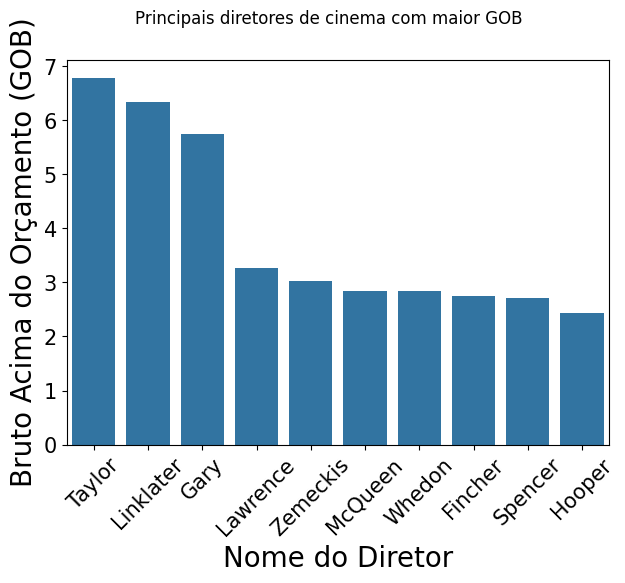

In [114]:
fig,ax = plt.subplots(figsize=(7, 5))

# Desenhando um gráfico de barras
ax = sns.barplot(x='director_familyName', y='GOB', data=top_GOB)

# Girando o nome dos diretores em 45 graus
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

# Título do nosso gráfico
fig.suptitle('Principais diretores de cinema com maior GOB', fontsize=12)

# Definindo o nome e o tamanho da fonte do rótulo dos eixos x e y
ax.set_xlabel('Nome do Diretor',fontsize=20)
ax.set_ylabel('Bruto Acima do Orçamento (GOB)',fontsize=20)

# Definindo o tamanho do tick do eixo
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)

# Mostra o gráfico
plt.show();

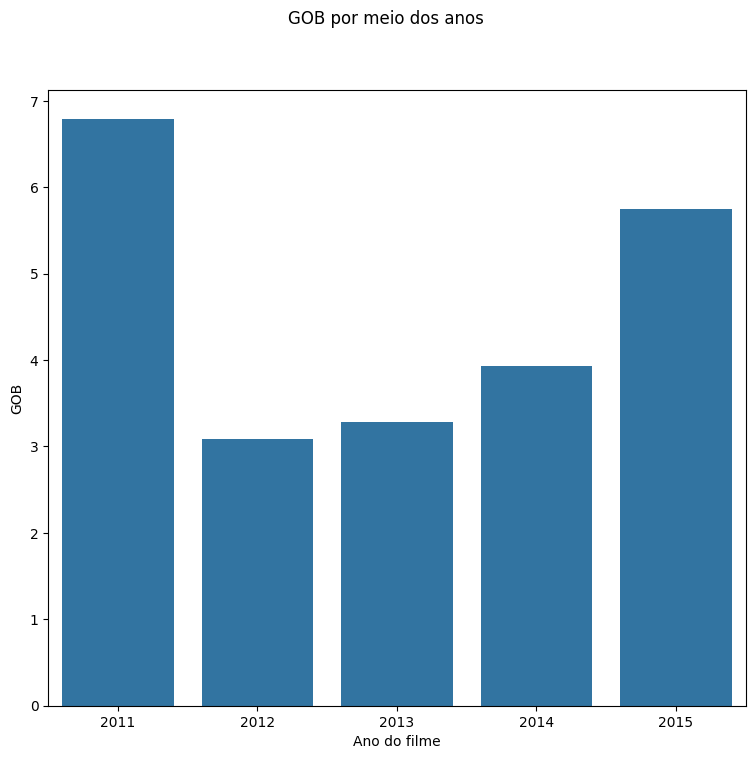

In [115]:
# Vamos fazer uma análise de tendências baseada em Clustering?

# Qual ano teve o maior GOB?

# O próximo relatório mostra os anos com altas pontuações brutas acima do orçamento para todos os filmes.
# Para fazer isso, devemos agrupar os registros com base em title_year.
# A tabela dinâmica em Python é usada para agrupar colunas e agregá-las com base em colunas numéricas, conforme mostrado no código a seguir.

# Dados de GOB com base no ano do filme

dataset_pivot=top_GOB.pivot_table(index=['title_year'], values=['GOB'], aggfunc=np.mean ,margins=True)

# A coluna do ano no conjunto de dados inclui alguns valores ausentes, iremos ignorá-los.

# Algumas células estão vazias na coluna do ano

# dataset_pivot = dataset_pivot.loc[dataset_pivot['title_year'] > 0]

# Não precisamos do último registro que inclui a métrica de resumo

dataset_pivot = dataset_pivot[:-1]

# Como o índice mudou após a criação de uma tabela dinâmica, redefinimos o índice

dataset_pivot.reset_index(inplace=True)

# Algumas células estão vazias na coluna do ano

# dataset_pivot =dataset_pivot.loc[dataset_pivot['title_year']>0]

fig,ax = plt.subplots(figsize=(9, 8))
ax=sns.barplot(x="title_year", y="GOB", data=dataset_pivot)
fig.suptitle('GOB por meio dos anos', fontsize=12)
plt.xlabel('Ano do filme')
plt.show()

# Podemos agrupar os filmes com base em suas pontuações GOB/IMDB?

Diante do que fizemos até agora, podemos escolher um algoritmo de clustering para encontrar grupos de dados. A escolha do algoritmo depende de vários fatores, incluindo a natureza dos dados, tamanho dos dados, número e tipos de recursos em nosso conjunto de dados, etc.

No exemplo, utilizaremos novamente o algoritmo K-Means, um dos algoritmos de cluster mais populares, que funciona iterativamente para atribuir cada ponto de dados a um dos 'K' grupos com base no
recursos que são fornecidos.

Em nosso conjunto de dados, procuramos uma relação entre uma pontuação GOB e IMDB para ver se podemos ou não agrupar filmes com base nessas duas métricas. Primeiro, precisamos especificar o número de clusters que procuramos.

No exemplo, iremos escolher três. Se você visualizar seus dados em um gráfico de dispersão, poderá deduzir o número de grupos que poderá obter do algoritmo, mas se não, não se preocupe. Você pode alterar o número de clusters posteriormente e executar o algoritmo novamente para ver se obtém um resultado melhor ou não!

Para tanto, acabei usando um gráfico de dispersão simples em Python para visualizar essas duas métricas (a pontuação GOB e IMDB) em um gráfico:

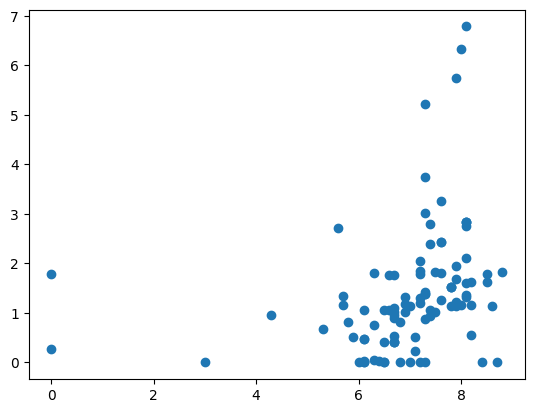

In [116]:
plt.scatter(x=dataset['imdb_score'], y=dataset['GOB'])
plt.show()

In [117]:
# Agora, vamos gerar clustering com três grupos.

from sklearn.cluster import KMeans

# Excluindo os valores ausentes e selecionando apenas a pontuação GOB e IMDB

selected_dataset=dataset.loc[
(dataset['GOB']>0) & dataset['imdb_score']>0][['imdb_score','GOB']]

# Agrupando o conjunto de dados usando o algoritmo K-Means

cls = KMeans(n_clusters=2)

# Ajustar o modelo ao algoritmo

cls.fit(selected_dataset)

# Trazendo os centróides e o rótulo de cada grupo

centroids=cls.cluster_centers_
labels = cls.labels_

# centroids
# red = selected_dataset[labels == 1]
# red
# green = selected_dataset[labels == 0]
# green

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


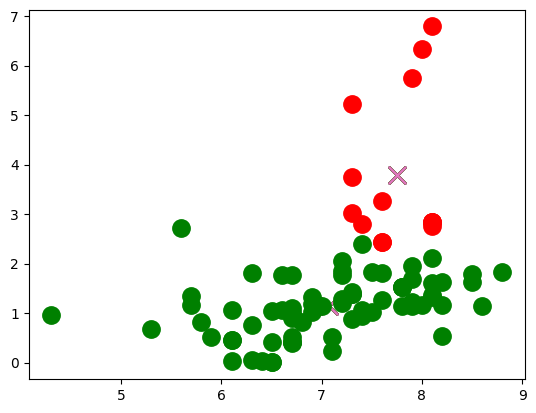

In [118]:
# Como próximo passo, vamos colorir os pontos com base em seus grupos e especificar o centro de cada grupo com um marcador (x).

# Temos três clusters, uma cor para cada cluster

colors = ["g.","r.","b.","y.","p"]

# Criando uma matriz de cada conjunto de dados para percorrer os pontos

dataset_array = np.array(selected_dataset)

# plotando o ponto em um gráfico de dispersão

for i in range(len(dataset_array)):
    plt.plot(dataset_array[i][0], dataset_array[i][1], colors [labels[i]], markersize =25);
    plt.scatter(centroids[:,0], centroids[:,1], marker='x', s=150);

Vemos então três clusters na figura: o primeiro cluster (azul) são os filmes com pontuação GOB baixa (não venderam bem) e pontuação baixa no IMDB (não foram bem classificados pelos usuários do IMDB).

O segundo grupo inclui os filmes com uma pontuação IMDB muito boa, mas não uma pontuação GOB muito alta. O terceiro cluster inclui poucos filmes com pontuações IMDB entre 7 e 8 e GOB muito alto.

Lembrando que esse é um subconjunto de filmes, você pode ter uma interpretação melhor aplicando o algoritmo em todos os filmes.

In [119]:
# E você, será que consegue descobrir alguma relação entre a pontuação do IMDB e as curtidas de filmes no Facebook? O que mais podemos descobrir a partir desse dataset, não somente a partir de clustering?

Para encontrar uma relação entre uma pontuação do IMDB e curtidas no Facebook podemos, por exemplo, usar um algoritmo de regressão.

Uma regressão linear simples pode ser usada para modelar a relação entre uma única variável independente de entrada (no nosso caso, curtidas no Facebook) e uma variável de saída (por exemplo, pontuação do IMDB) usando um modelo linear, ou seja, uma linha.

Este é apenas um exemplo. Na realidade, podemos não encontrar uma relação linear entre duas variáveis num conjunto de dados.

In [120]:
## RESPOSTA


## RESPOSTA